In [1]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
from models import resnet18
from data.datasets import CLONE_CLASSES, get_transforms
from CFG import CFG
import torch
import pandas as pd
import cv2 
import os
import string
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import copy

In [2]:
transforms = get_transforms(train=False)

In [3]:
model = resnet18(num_classes=len(CLONE_CLASSES))
device = CFG.DEVICE
checkpoint_dict = torch.load('./exp/20211109_2152_30_v3_day6/model_best_acc.pth')
model.load_state_dict(checkpoint_dict['state_dict'])
model = model.to(device)

In [4]:
df_gt = pd.read_csv('../data/test_day6.csv')
df_gt['label_gt'] = df_gt['label'].apply(lambda x: x.strip(string.digits))
df_dt = pd.read_csv('./test_res.csv')
df_dt['label_dt'] = df_dt[CLONE_CLASSES].idxmax(1)
df = pd.concat((df_gt, df_dt), axis=1)

In [5]:
df_cur = df[(df['label_gt']=='meroclone') | (df['label_dt']=='meroclone')].sample(1)
# df_cur = df.sample(1)

In [6]:
img = cv2.imread(os.path.join('../data/img_clip_all', df_cur.iloc[0]['filename_gfp']))
x1, y1, x2, y2 = df_cur[['x1', 'y1', 'x2', 'y2']].values[0]
rgb_img = img[y1: y2, x1: x2] 
resized_img = cv2.resize(
    rgb_img,
    (224, 224), # (w, h)
    interpolation=cv2.INTER_LINEAR,
).astype(np.uint8)
# img_patch = transforms(rgb_img)
img_patch = transforms(Image.fromarray(resized_img))
target_category = CLONE_CLASSES.index(df_cur.iloc[0]['label'].strip(string.digits))

In [7]:
# target_category = 2

In [8]:
cam = GradCAM(model=model, target_layers=[model.layer3[-1]], use_cuda=device)
grayscale_cam = cam(input_tensor=img_patch.unsqueeze(0), target_category=target_category)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image((resized_img/255.).astype(float), grayscale_cam, use_rgb=True)

/data/home/v_lihlihli/miniconda3/envs/qs/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
gb_model = GuidedBackpropReLUModel(model=copy.deepcopy(model), use_cuda=device)
gb = gb_model(img_patch.unsqueeze(0), target_category=target_category)
cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_gb = deprocess_image(cam_mask * gb)
gb = deprocess_image(gb)

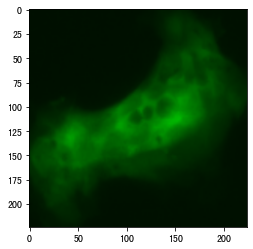

In [10]:
plt.imshow(resized_img)

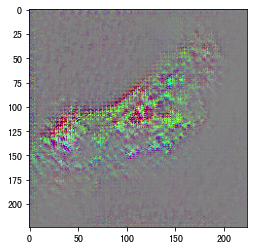

In [11]:
plt.imshow(gb)

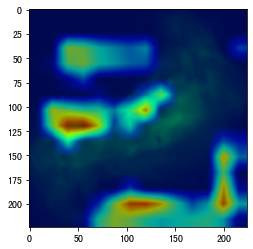

In [12]:
plt.imshow(visualization)

In [13]:
df_cur

,day,label,size,width,height,filename,filename_gfp,filename_ph,x1,y1,...,clip_y2,batch,bbox_idx,image_id,label_gt,image_id,holoclone,meroclone,paraclone,label_dt
880,6,paraclone25,1344,145,119,1636428249_855166.png,1636428249_855166_gfp.png,1636428249_855166_ph.png,668,1124,...,10271,0,880,398,paraclone,398.0,0.223255,0.519213,0.257532,meroclone
